In [162]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [163]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [164]:
NUM_CLASSES = 10

# Dataset reading

In [165]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [166]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [168]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [169]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [170]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [171]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [172]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
14/14 [==============================] - ETA: 0s - loss: 2.3757 - accuracy: 0.1094
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 1s 25ms/step - loss: 2.3757 - accuracy: 0.1094 - val_loss: 2.3223 - val_accuracy: 0.1594
Epoch 2/1000
14/14 [==============================] - ETA: 0s - loss: 2.3437 - accuracy: 0.1216
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 12ms/step - loss: 2.3437 - accuracy: 0.1216 - val_loss: 2.3119 - val_accuracy: 0.1436
Epoch 3/1000
13/14 [==========================>...] - ETA: 0s - loss: 2.3202 - accuracy: 0.1238
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 14ms/step - loss: 2.3196 - accuracy: 0.1246 - val_loss: 2.3048 - val_accuracy: 0.1454
Epoch 4/1000
14/14 [==============================] - ETA: 0s - loss: 2.3188 - accuracy: 0.109

In [173]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 4ms/step - loss: 0.4754 - accuracy: 0.9702


In [174]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [175]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 61ms/step
[1.2338357e-02 8.9176768e-01 2.2834606e-02 3.3859532e-02 4.2605205e-03
 4.8268071e-04 3.5402447e-03 1.4976622e-02 1.5935158e-02 4.5679158e-06]
1


# Confusion matrix

18/18 [==============================] - 0s 2ms/step


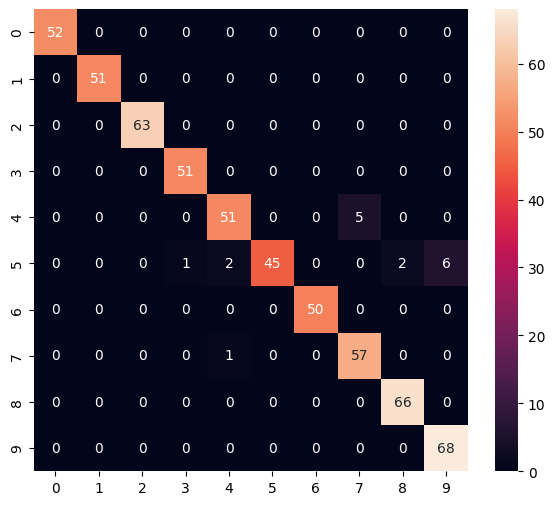

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        63
           3       0.98      1.00      0.99        51
           4       0.94      0.91      0.93        56
           5       1.00      0.80      0.89        56
           6       1.00      1.00      1.00        50
           7       0.92      0.98      0.95        58
           8       0.97      1.00      0.99        66
           9       0.92      1.00      0.96        68

    accuracy                           0.97       571
   macro avg       0.97      0.97      0.97       571
weighted avg       0.97      0.97      0.97       571



In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [177]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [178]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmpg7got41a\assets


INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmpg7got41a\assets


6872

# Inference test

In [179]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [180]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [181]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [182]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [183]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.2338368e-02 8.9176768e-01 2.2834625e-02 3.3859562e-02 4.2605242e-03
 4.8268118e-04 3.5402479e-03 1.4976636e-02 1.5935166e-02 4.5679253e-06]
1
